In [102]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.cluster import KMeans, DBSCAN
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, StandardScaler, MinMaxScaler, OrdinalEncoder
from sklearn.compose import ColumnTransformer
from sklearn.metrics import silhouette_samples, silhouette_score

import umap

import warnings
warnings.filterwarnings('ignore')

In [43]:
column_names = []
with open('/content/drive/MyDrive/JPMC Assessment/data/census-bureau.columns', 'r') as f:
    for line in f:
        column_names.append(line.strip().replace(" ","_"))

df = pd.read_csv("/content/drive/MyDrive/JPMC Assessment/data/census-bureau.data", delimiter=",")
df.columns = column_names

In [44]:
df = df.copy()
rename_dict = {
    "fill_inc_questionnaire_for_veteran's_admin": "fill_inc_questionnaire_for_veterans_admin",
    'migration_code-change_in_msa': 'migration_code_change_in_msa',
    'migration_code-change_in_reg': 'migration_code_change_in_reg',
    'migration_code-move_within_reg': 'migration_code_move_within_reg'
}
df['hispanic_origin'] = df['hispanic_origin'].fillna('Do not know')
df.rename(columns=rename_dict, inplace=True)
df['label'] = df['label'].map({'- 50000.':0, '50000+.':1})  # Map values to 1 & 0
df['net_gains'] = (df['capital_gains'] + df['dividends_from_stocks'] - df['capital_losses'])

- For clustering and Segmentaion purposes for marketing, keeping only quantititive columns will help understand and interpret the clusters i.e. customer segments in the census.
- Hence, based on the EDA in another file, dropping a few columns which do not add up significantly in model predictions. These columns mainly contain the information of region, country of birth and information of veterans benefits.
- Dropping wage_per_hour as Net gains are calculated already.
- Dropping Reason for employment which is just the information and will not be as important while clustering.
- Dropping detailed_occupation_recode and detailed_industry_recode as these are numerical columns and there are other overlapping categorical columns which give us the information about industry and occupation, which is easy to interpret, visualize and understand.
- Keeping both Race and hispanic origin features
- Removing country_of_birth_father and country_of_birth_mother as this information is not much relevant for marketing
- Dropping member of labour union flag as most of the data belong to Not in universe, and less revelant for marketing
- Keeping only migration_code_change_in_reg, and removing migration_code_change_in_msa and migration_code_move_within_reg as we get to know the migration status of customer/person from reg code and market those, other two columns are overlapping.
- Keeping Citizenship to understand the active engagement of people who are native or migrated.
- Dropping num_persons_worked_for_employer and family_members_under_18

- Note: Depending on the business requirement, we can keep or remove the columns as needed, I kept the following columns for clustering algorithm as I thought they are important and descriptive and cover majority of the significant features that are important in real life.

In [90]:
cols_to_drop = ['label', 'weight', 'capital_gains', 'dividends_from_stocks', 'capital_losses', 'fill_inc_questionnaire_for_veterans_admin', 'veterans_benefits', 'year',
                'enroll_in_edu_inst_last_wk', 'country_of_birth_self', 'region_of_previous_residence', 'state_of_previous_residence', 'reason_for_unemployment', 'wage_per_hour', 'detailed_industry_recode',
                'detailed_occupation_recode', 'country_of_birth_father', 'country_of_birth_mother', 'member_of_a_labor_union', 'migration_code_change_in_msa', 'migration_code_move_within_reg',
                'migration_prev_res_in_sunbelt', 'num_persons_worked_for_employer', 'family_members_under_18']

X = df.drop(columns=cols_to_drop)

In [93]:
# Get the Numeric and Categorical Features Separately
numeric_features = X.select_dtypes(include=['int64', 'float64']).columns.tolist()
categorical_features = X.select_dtypes(include=['object', 'category']).columns.tolist()

# Transform the Features to Impute Missing values, with methods like (median, most_frequent, mean, etc) but this has already been taken care while preprocessing
# Scale the numeric values, Encode the categorical values
numeric_transformer = Pipeline(
    steps=[
        ('scaler', MinMaxScaler())
    ]
)

# Convert all the categorical features using OneHotEncoding for a few models and OrdinalEncoding for another for standardized conversion
ohe_categorical_transformer = Pipeline(
    steps=[
        ('encoder', OneHotEncoder(handle_unknown='ignore', sparse_output=True))
    ]
)

# Preprocess with the above Transformations for Linear models
lr_preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', ohe_categorical_transformer, categorical_features)
    ],
    remainder='drop'
)

In [95]:
# Fit and transform data
X_scaled_sparse = lr_preprocessor.fit_transform(X)
X_scaled_dense = X_scaled_sparse.toarray()

print(f"Original Feature Dimensions after Preprocessing: {X_scaled_dense.shape}")

Original Feature Dimensions after Preprocessing: (199522, 169)


- As we can see from the above that we have higher dimensionality (169), we can use PCA/t-SNE/UMAP to reduce the dimensionality of the data before clustering algorithm.
- Using PCA for Dimensionality reduction and UMAP for visualization as it is faster than t-SNE.

In [96]:
# PCA with 90% variance
pca = PCA(n_components=0.90, random_state=7)
X_pca = pca.fit_transform(X_scaled_dense)

print(f"Dimensions after PCA: {X_pca.shape}")
print(f"Number of Principal Components used: {pca.n_components_}")

Dimensions after PCA: (199522, 43)
Number of Principal Components used: 43


- We can use the Elbow method to find the optimal number of clusters, it contains WCSS (within cluster sum of squares) method where if the adding more clusters does not reduce the WCSS, we can stop at that point.
- We can compare various algorithms to find the optimal K, here I will use "k-means" and "k-means++" algorithms to find K, and then choose overlapping K.

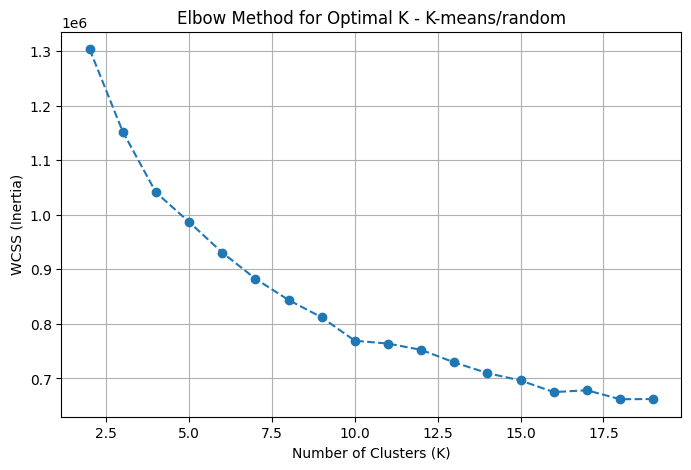

In [100]:
# wcss with k-means
wcss = []
k_range = range(2, 20) # Test K from 2 to 20

for k in k_range:
    kmeans = KMeans(n_clusters=k, init='random', n_init=10, max_iter=300, random_state=7)
    kmeans.fit(X_pca)
    wcss.append(kmeans.inertia_)

# Plot the Elbow Curve
plt.figure(figsize=(8, 5))
plt.plot(k_range, wcss, marker='o', linestyle='--')
plt.title('Elbow Method for Optimal K - K-means/random')
plt.xlabel('Number of Clusters (K)')
plt.ylabel('WCSS (Inertia)')
plt.grid(True)
plt.show()

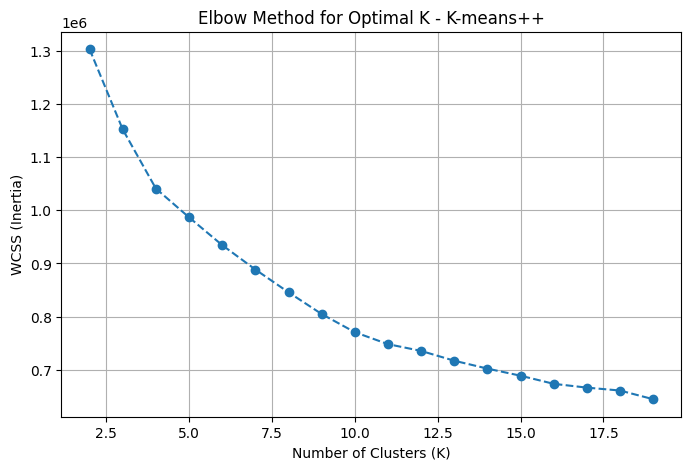

In [101]:
# wcss with k-means++
wcss = []
k_range = range(2, 20) # Test K from 2 to 20

for k in k_range:
    kmeans = KMeans(n_clusters=k, init='k-means++', n_init=10, max_iter=300, random_state=7)
    kmeans.fit(X_pca)
    wcss.append(kmeans.inertia_)

# Plot the Elbow Curve
plt.figure(figsize=(8, 5))
plt.plot(k_range, wcss, marker='o', linestyle='--')
plt.title('Elbow Method for Optimal K - K-means++')
plt.xlabel('Number of Clusters (K)')
plt.ylabel('WCSS (Inertia)')
plt.grid(True)
plt.show()

- As you can see above that there is sudden drop till number 4 and then steady drop in the number of groups. It is quite tough to find the optimal number of K as we have more features, however in the first plot, after 10 clusters the graph is constant and there is not significant change after, comparing both the plots, selecting K = 10
- Once we fit the model, we can check the silhouette score [-1, 1] which measures how similar the entry is to its own cluster compared to other cluster. A score near to 1 means that object is well matched and a score near to -1 means it does not.

In [105]:
# Set K
OPTIMAL_K = 10

# Final K-Means Model
kmeans = KMeans(n_clusters=OPTIMAL_K, init='k-means++', n_init=10, max_iter=300, random_state=7)
df['segment'] = kmeans.fit_predict(X_pca)

# Silhoutte Score Average
sil_score = silhouette_score(X_pca, kmeans.labels_)

print("Silhouette Score Avg:", sil_score)

Silhouette Score Avg: 0.19918795905493558


# Cluster Interpretation for Marketing
- Sample interpretation

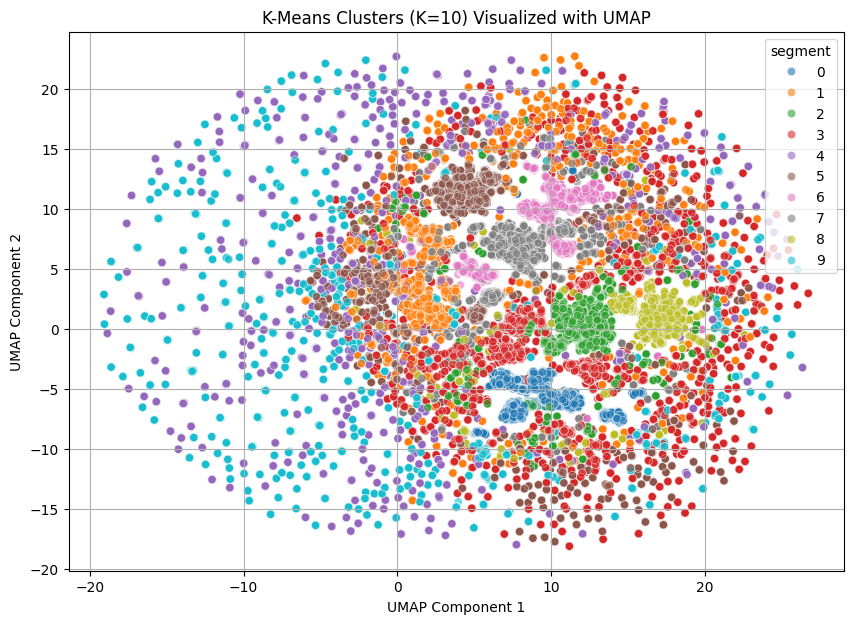

In [106]:
# UMAP for visualization
reducer = umap.UMAP(random_state=7, n_components=2)
embedding = reducer.fit_transform(X_pca)

df_umap_viz = pd.DataFrame(data=embedding, columns=['UMAP1', 'UMAP2'])
df_umap_viz['segment'] = df['segment']

# Plot the clusters using UMAP embedding
plt.figure(figsize=(10, 7))
sns.scatterplot(
    x='UMAP1',
    y='UMAP2',
    hue='segment',
    data=df_umap_viz,
    palette=sns.color_palette('tab10', n_colors=OPTIMAL_K),
    legend='full',
    alpha=0.6
)
plt.title(f'K-Means Clusters (K={OPTIMAL_K}) Visualized with UMAP')
plt.xlabel('UMAP Component 1')
plt.ylabel('UMAP Component 2')
plt.grid(True)
plt.show()

In [109]:
df['segment'].value_counts()

,count
segment,
9,27745
4,25243
3,23744
5,20788
0,19674
6,19528
7,16568
2,16408
1,16193


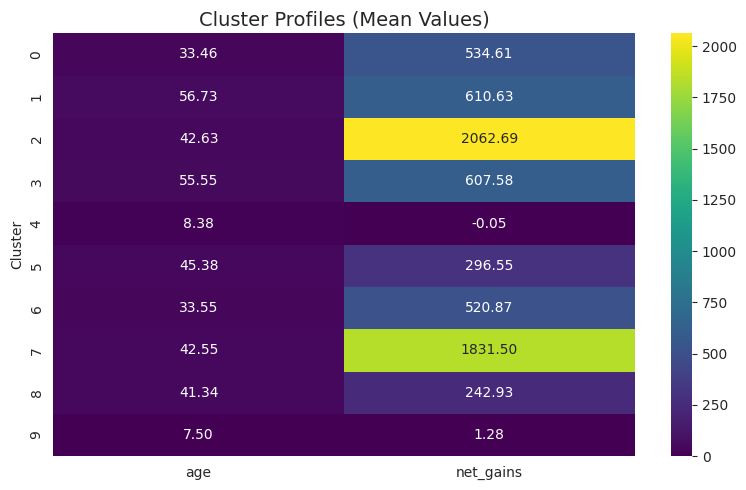

In [122]:
cluster_profile = (
    df.groupby('segment')[['age', 'net_gains']]
      .mean()
)
plt.figure(figsize=(8, 5))
sns.heatmap(
    cluster_profile,
    annot=True,
    fmt=".2f",
    cmap='viridis'
)

plt.title('Cluster Profiles (Mean Values)', fontsize=14)
plt.ylabel('Cluster')
plt.tight_layout()
plt.show()


- As you can see from the above, clusters 9 (27745) and 4 (25243) are the youngest with average ages 7- 8, and their net gains are also low/negative.
- Clusters 0,5, 6, 8 are mid range (age: 33 to 45) and low to mid range of Net gains (242 to 534), these can be considered as average segments, can be upscaled.
- Clusters 2 & 7, age(42-43) have extremely high net gains (1831 to 2062), they are most valuable hence can be focused for retention and growth strategy
- Clusters 1 & 3 are oldest and the net gain is also intermediate, these clusters could provide solid but not peak gains


- You can also see that the clusters are repeatitive, for example cluster 2 and 7 have similar mean age, 1 and 3, 7 and 8. We can also reduce the number of clusters here but I am keeping it as 10 for more granularity.
- We can also further analyse a particular cluster, for example we can take cluster 2 and find how male to female ratio will be used for marketing, how is the distribution of occupation and industry is for targeting, education of people in clusters, race and origin based marketing and develop marketing strategies accordinly.